In [14]:
from pathlib import Path
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
# from sklearn.preprocessing import MinMaxScaler
import pytorch_lightning as pl
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

In [ ]:
SYMBOLS = {
    i: idx
    for idx, i in enumerate(
        [
            "BTCUSDT",
            "ETHUSDT",
            "SOLUSDT",
            "BNBUSDT",
            "XRPUSDT",
            "WIFUSDT",
            "DOGEUSDT",
            "PEPEUSDT",
            "SPELLUSDT",
            "SUIUSDT",
            "ADAUSDT",
            "RVNUSDT",
            "JUVUSDT",
            "OMUSDT",
            "LTCUSDT",
            "CREAMUSDT",
            "ACMUSDT",
            "CITYUSDT",
            "TSTUSDT",
            "ATMUSDT",
            "USUALUSDT",
            "DATAUSDT",
            "PORTOUSDT",
            "BARUSDT",
            "TRXUSDT",
            "XLMUSDT",
            "LINKUSDT",
            "JUPUSDT",
            "BNXUSDT",
            "PNUTUSDT",
            "CAKEUSDT",
            "SHIBUSDT",
            "WBTCUSDT",
            "AVAXUSDT",
            "HBARUSDT",
            "TONUSDT",
            "DOTUSDT",
        ]
    )
}

In [ ]:
data_root = Path("dataset/bn_spider/csv/")
data_path = data_root / "BNBUSDT_60.csv"
seq_path = data_root / "seq_60.csv"
# data_df = pd.read_csv(data_path)
# seq_df = pd.read_csv(seq_path)

In [ ]:
# seq = seq_df[seq_df["stock_name"]=="BNBUSDT"]
# seq

In [ ]:
# 读取和预处理 CSV 数据
def load_and_preprocess_data(file_path, interval):
    # 读取 CSV 文件
    data = pd.read_csv(file_path).dropna()

    # 处理缺失值
    data.fillna(value=0, inplace=True)  # 使用前向填充方法处理缺失值

    # # 将 datetime 列转换为时间戳
    # data["timestamp"] = (
    #     pd.to_datetime(data["datetime"]).astype("int64") // 10**9
    # )  # 转换为秒级时间戳

    # # 排序 timestamp
    # data = data.sort_values(by="timestamp", ascending=True)

    # # make index
    # # interval = 14400
    # data["timestamp_diff"] = data["timestamp"].diff().fillna(0).astype("int64")

    # use csv in bn_spider
    interval *= 1000
    data = data.sort_values(by="open_time", ascending=True)
    data["timestamp_diff"] = data["open_time"].diff().fillna(0).astype("int64")

    # seq = pd.DataFrame(columns=["start", "end", "length"])
    # start = 0
    # seq_list = []
    # idx = 0
    # row = None
    # for idx, row in tqdm(data.iterrows(), total=len(data)):
    #     if row.timestamp_diff != interval:
    #         if idx == 0:
    #             continue
    #         seq_list.append([start, idx, idx - start])
    #         start = idx
    # if idx > 0:
    #     idx += 1
    #     seq_list.append([start, idx, idx - start])
    # seq = pd.DataFrame(seq_list, columns=["start", "end", "length"])

    # 使用 shift 和 cumsum 来划分序列
    data["is_new_seq"] = (data["timestamp_diff"] != interval).astype(int)
    data["seq_id"] = data["is_new_seq"].cumsum()

    # 计算每个序列的 start, end, length
    seq = (
        data.groupby("seq_id")
        .agg(
            start=("open_time", "idxmin"),
            end=("open_time", "idxmax"),
            length=("open_time", "size"),
        )
        .reset_index(drop=True)
    )
    seq["end"] += 1

    # gen_seq = generate_fixed_length_sequences(seq, 5)

    # # 提取特征
    # features = data[["open", "high", "low", "close", "volume"]].values

    # # 归一化处理
    # scaler = MinMaxScaler()
    # features_scaled = scaler.fit_transform(features)

    # return data[["open", "high", "low", "close", "volume"]].values, seq

    return (
        data[
            [
                # "stock_name",
                # # "open_time",
                # "interval",
                # "open_price",
                # "high_price",
                "low_price",
                "close_price",
                "volume",
                # "close_time",
                # "quote_asset_volume",
                # "number_of_trades",
                # "taker_buy_base_asset_volume",
                # "taker_buy_quote_asset_volume",
            ]
        ].values,
        seq,
    )


In [ ]:
def generate_fixed_length_sequences(df, fixed_length):
    """
    将每个连续区间分割为固定长度的子序列，返回无交叉的区间列表

    参数:
    df (DataFrame): 包含列['start', 'end', 'length']的连续性统计表
    fixed_length (int): 需要生成的固定子序列长度

    返回:
    List[Tuple]: 生成的子序列区间列表，格式为 [(start1, end1), (start2, end2), ...]
    """
    result = []

    for _, row in df.iterrows():
        s = row["start"]
        e = row["end"]
        length = row["length"]
        

        # 跳过长度不足的区间
        if length < fixed_length:
            continue

        # 完全匹配的情况
        if length == fixed_length:
            result.append((s, e))
            continue

        # form offset
        if length // fixed_length == 1:
            offset = np.random.randint(0, length % fixed_length + 1)
        else:
            offset = np.random.randint(0, fixed_length)

        # 生成每个子序列的起始和结束位置
        s += offset
        e = s + fixed_length
        while e <= length+row["start"]:
            result.append((s, e))
            s = e
            e += fixed_length

    return result


In [ ]:
# 创建自定义数据集类
class SeqDataset(Dataset):
    def __init__(self, data, seq, sequence_length, predict_length):
        self.data = data
        self.seq = seq
        self.seqList_x = None
        self.seqList_y = None
        # symbol_mapper = np.vectorize(lambda s: SYMBOLS[s])
        # self.data[:, 0] = symbol_mapper(self.data[:, 0])
        self.data = self.data.astype(np.float64)
        self.scaler = None
        # self.scaler = MinMaxScaler(feature_range=(0, 1))
        # self.data = self.scaler.fit_transform(self.data)
        self.sequence_length = sequence_length
        self.predict_length = predict_length

        self.scaler = StandardScaler()
        # self.scaler.fit(self.seqList_x)
        self.scaler.fit(self.data)
        self.data = self.scaler.transform(self.data)
        self.__shuffle__()

    def __shuffle__(self):
        seqs = generate_fixed_length_sequences(
            self.seq, self.sequence_length + self.predict_length
        )
        self.seqList_x = []
        self.seqList_y = []
    
        for seq in seqs:
            data = self.data[seq[0] : seq[1]]

            x = data[0 : self.sequence_length]
            y = data[self.sequence_length :]
            self.seqList_x.append(x)
            self.seqList_y.append(y)
        self.seqList_x = torch.tensor(self.seqList_x, dtype=torch.float32)
        # self.seqList_y = torch.tensor(self.seqList_y, dtype=torch.float32)
        # if self.scaler is None:
        #     self.scaler = StandardScaler()
        #     # self.scaler.fit(self.seqList_x)
        #     self.scaler.fit(self.data)
        # self.seqList_x = self.scaler.transform(self.seqList_x)
        # self.seqList_y = self.scaler.transform(self.seqList_y)
        
    def inverse_transform(self, data):
        return self.scaler.inverse_transform(data)

    def reshuflle(self):
        self.__shuffle__()

    def __len__(self):
        return len(self.seqList_x)

    def __getitem__(self, idx):
        x = self.seqList_x[idx]
        y = self.seqList_y[idx]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(
            y, dtype=torch.float32
        )

In [ ]:
seq_steps=60*24*7
predict_steps=60*24
data, seq = load_and_preprocess_data(data_path, 60)
dataset = SeqDataset(data, seq,seq_steps,predict_steps)
len(dataset)

/tmp/ipykernel_166258/723976692.py:37: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647382455/work/torch/csrc/utils/tensor_new.cpp:278.)
  self.seqList_x = torch.tensor(self.seqList_x, dtype=torch.float32)


312

In [ ]:
dataset.__getitem__(0)[0].shape, dataset.__getitem__(0)[1].shape

/tmp/ipykernel_166258/723976692.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x, dtype=torch.float32), torch.tensor(


(torch.Size([10080, 3]), torch.Size([1440, 3]))

In [ ]:
batch_size = 16
dataloader = DataLoader(dataset, batch_size=batch_size)

In [ ]:
# 2. 定义LSTM模型
class MultiVarLSTM(nn.Module):
    def __init__(self, input_size=3, hidden_size=64, output_size=3, num_layers=2, seq_steps=10080, predict_steps=1440):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.2
        )
        self.seq_steps = seq_steps
        self.predict_steps = predict_steps
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 32),
            nn.ReLU(),
            nn.Linear(32, output_size*predict_steps)  # 输出为predict_steps*3
        )
    
    def forward(self, x):
        # x shape: (batch_size, time_steps, input_size)
        out, (h_n, c_n) = self.lstm(x)
        # 取最后一个时间步的输出
        out = self.fc(out[:, -1, :])
        # 调整形状为 (batch_size, predict_steps, 3)
        return out.view(-1, predict_steps, 3)

In [ ]:
# 初始化模型
model = MultiVarLSTM(
    input_size=3,
    hidden_size=64,
    output_size=3,
    num_layers=2
).cuda()


In [ ]:
# 4. 训练函数
epochs=100
device="cuda:0"
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5)

model.train()
for epoch in range(epochs):
    total_loss = 0
    loop = tqdm(dataloader, total=len(dataloader))
    for X_batch, y_batch in loop:
        optimizer.zero_grad()
        outputs = model(X_batch.to(device))
        loss = criterion(outputs, y_batch.to(device))
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # 梯度裁剪
        optimizer.step()
        total_loss += loss.item()
    
    avg_loss = total_loss / len(dataloader)
    scheduler.step(avg_loss)
    print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}')
    dataset.reshuflle()


  0%|          | 0/20 [00:00<?, ?it/s]/tmp/ipykernel_166258/723976692.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x, dtype=torch.float32), torch.tensor(
100%|██████████| 20/20 [00:01<00:00, 14.56it/s]


Epoch 1/100, Loss: 1.0692


100%|██████████| 20/20 [00:01<00:00, 18.97it/s]


Epoch 2/100, Loss: 1.0222


100%|██████████| 20/20 [00:01<00:00, 18.00it/s]


Epoch 3/100, Loss: 0.8774


100%|██████████| 20/20 [00:01<00:00, 17.94it/s]


Epoch 4/100, Loss: 0.6080


100%|██████████| 20/20 [00:01<00:00, 18.16it/s]


Epoch 5/100, Loss: 0.4787


100%|██████████| 20/20 [00:01<00:00, 17.93it/s]


Epoch 6/100, Loss: 0.4065


100%|██████████| 20/20 [00:01<00:00, 18.39it/s]


Epoch 7/100, Loss: 0.3362


100%|██████████| 20/20 [00:01<00:00, 18.36it/s]


Epoch 8/100, Loss: 0.2811


100%|██████████| 20/20 [00:01<00:00, 17.71it/s]


Epoch 9/100, Loss: 0.2932


100%|██████████| 20/20 [00:01<00:00, 18.35it/s]


Epoch 10/100, Loss: 0.3350


100%|██████████| 20/20 [00:01<00:00, 18.34it/s]


Epoch 11/100, Loss: 0.3155


100%|██████████| 20/20 [00:01<00:00, 18.38it/s]


Epoch 12/100, Loss: 0.3252


100%|██████████| 20/20 [00:01<00:00, 18.35it/s]


Epoch 13/100, Loss: 0.2846


100%|██████████| 20/20 [00:01<00:00, 18.42it/s]


Epoch 14/100, Loss: 0.3250


100%|██████████| 20/20 [00:01<00:00, 18.29it/s]


Epoch 15/100, Loss: 0.2997


100%|██████████| 20/20 [00:01<00:00, 18.49it/s]


Epoch 16/100, Loss: 0.2685


100%|██████████| 20/20 [00:01<00:00, 17.92it/s]


Epoch 17/100, Loss: 0.3337


100%|██████████| 20/20 [00:01<00:00, 19.01it/s]


Epoch 18/100, Loss: 0.3146


100%|██████████| 20/20 [00:01<00:00, 18.28it/s]


Epoch 19/100, Loss: 0.2661


100%|██████████| 20/20 [00:01<00:00, 18.34it/s]


Epoch 20/100, Loss: 0.2748


100%|██████████| 20/20 [00:01<00:00, 18.43it/s]


Epoch 21/100, Loss: 0.2832


100%|██████████| 20/20 [00:01<00:00, 17.30it/s]


Epoch 22/100, Loss: 0.2390


100%|██████████| 20/20 [00:01<00:00, 18.36it/s]


Epoch 23/100, Loss: 0.3470


100%|██████████| 20/20 [00:01<00:00, 18.42it/s]


Epoch 24/100, Loss: 0.3124


100%|██████████| 20/20 [00:01<00:00, 17.79it/s]


Epoch 25/100, Loss: 0.2860


100%|██████████| 20/20 [00:01<00:00, 18.35it/s]


Epoch 26/100, Loss: 0.2882


100%|██████████| 20/20 [00:01<00:00, 18.32it/s]


Epoch 27/100, Loss: 0.2609


100%|██████████| 20/20 [00:01<00:00, 18.43it/s]


Epoch 28/100, Loss: 0.2577


100%|██████████| 20/20 [00:01<00:00, 18.39it/s]


Epoch 29/100, Loss: 0.3218


KeyboardInterrupt: 

In [ ]:
outputs

tensor([[[163.8413, 151.3713, 178.5954],
         [146.1174, 154.1814, 203.3187],
         [138.1286, 134.5786, 161.5634],
         ...,
         [140.5328, 150.9165, 171.8488],
         [141.1443, 156.0444, 172.7906],
         [142.2856, 144.6543, 167.3370]],

        [[163.8372, 151.3676, 178.5910],
         [146.1138, 154.1775, 203.3136],
         [138.1251, 134.5752, 161.5594],
         ...,
         [140.5293, 150.9128, 171.8445],
         [141.1408, 156.0406, 172.7863],
         [142.2820, 144.6507, 167.3329]],

        [[163.8411, 151.3711, 178.5952],
         [146.1172, 154.1811, 203.3184],
         [138.1284, 134.5784, 161.5632],
         ...,
         [140.5326, 150.9163, 171.8485],
         [141.1441, 156.0442, 172.7904],
         [142.2854, 144.6541, 167.3368]],

        [[163.8412, 151.3713, 178.5953],
         [146.1174, 154.1813, 203.3186],
         [138.1285, 134.5785, 161.5634],
         ...,
         [140.5327, 150.9165, 171.8487],
         [141.1442, 156.0444, 172.79

# 预测与可视化

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
dataset.reshuflle()
test_idx = np.random.choice(range(len(dataset)), 1, replace=False)
test_data = dataset.__getitem__(test_idx[0])

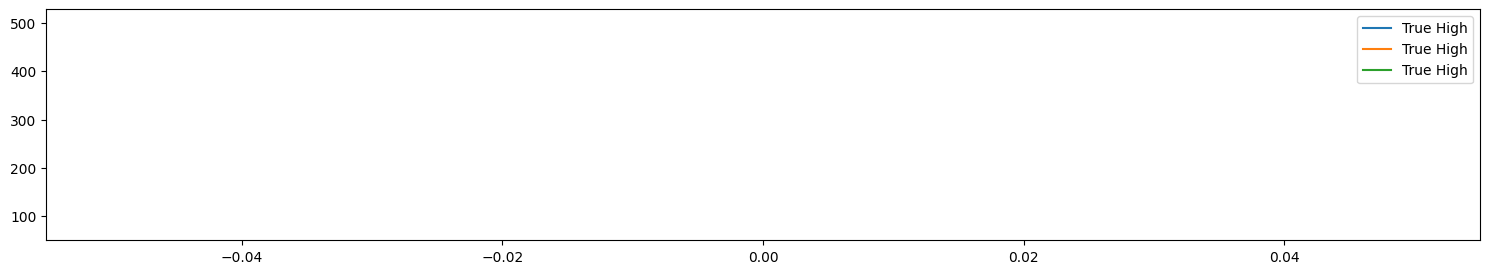

In [ ]:
model.eval()

with torch.no_grad():
    # 取最后time_steps作为输入
    inputs = test_data[0].unsqueeze(0)
    # inputs = scaler.transform(inputs)
    # inputs = torch.tensor(inputs, dtype=torch.float32).unsqueeze(0)
    
    prediction = model(inputs.to(device)).squeeze(0).cpu().numpy()
    # prediction = scaler.inverse_transform(prediction.reshape(-1, 3))

